In [46]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [47]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    # Encoder layers
    self.fc1 = nn.Linear(784, 400) # Input dimension is 784 (28x28 flattened image)
    self.fc2_mu = nn.Linear(400, latent_dim) # Output mean vector
    self.fc2_logvar = nn.Linear(400, latent_dim) # Output log variance vector
    # Decoder layers
    self.fc3 = nn.Linear(latent_dim, 400)
    self.fc4 = nn.Linear(400, 784) # Output dimension is 784

  def encode(self, x):
    # Encode the input image into mean and log variance vectors
    h1 = torch.relu(self.fc1(x))
    mu = self.fc2_mu(h1)
    logvar = self.fc2_logvar(h1)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    # Reparameterize the mean and log variance vectors into a latent vector
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std) # Random noise
    z = mu + eps*std # Latent vector
    return z

  def decode(self, z):
    # Decode the latent vector into an output image
    h3 = torch.relu(self.fc3(z))
    out = torch.sigmoid(self.fc4(h3))
    return out

  def forward(self, x):
    # Forward pass of the VAE
    mu, logvar = self.encode(x.view(-1, 784)) # Encode the input image
    z = self.reparameterize(mu, logvar) # Reparameterize into a latent vector
    out = self.decode(z) # Decode into an output image
    return out, mu, logvar

In [48]:
# Define the loss function (reconstruction loss + KL divergence)
def loss_function(out, x, mu, logvar):
  # Reconstruction loss (binary cross entropy)
  BCE = nn.functional.binary_cross_entropy(out, x.view(-1, 784), reduction='sum')
  # KL divergence (analytical solution)
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  # Total loss
  loss = BCE + KLD
  return loss

In [49]:
# Define hyperparameters
batch_size = 100 # Number of images per batch
latent_dim = 10 # Dimension of the latent vector
epochs = 15 # Number of training epochs

In [50]:
# Create a transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# Create train and test dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
# Create an instance of the VAE model
model = VAE().to(device)

In [52]:
# Define the optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [53]:
# Training loop
for epoch in range(epochs):
  # Set the model to training mode
  model.train()
  # Initialize the train loss
  train_loss = 0
  # Loop over the train batches
  for batch_idx, (x, _) in enumerate(train_loader):
    # Move the input data to the device
    x = x.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass of the model
    out, mu, logvar = model(x)
    # Compute the loss
    loss = loss_function(out, x, mu, logvar)
    # Backward pass of the model
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Update the train loss
    train_loss += loss.item()
    # Print the progress
    if batch_idx % 100 == 0:
      print(f"Train Epoch: {epoch+1} [{batch_idx * len(x):5d}/{len(train_loader.dataset)}] Loss: {loss.item() / len(x):.4f}")
  # Print the average train loss per epoch
  print(f"====> Epoch: {epoch+1} Average loss: {train_loss / len(train_loader.dataset):.4f}")

Train Epoch: 1 [    0/60000] Loss: 549.2890
Train Epoch: 1 [10000/60000] Loss: 143.6868
Train Epoch: 1 [20000/60000] Loss: 127.0859
Train Epoch: 1 [30000/60000] Loss: 121.7677
Train Epoch: 1 [40000/60000] Loss: 115.1906
Train Epoch: 1 [50000/60000] Loss: 123.6716
====> Epoch: 1 Average loss: 135.7009
Train Epoch: 2 [    0/60000] Loss: 117.2242
Train Epoch: 2 [10000/60000] Loss: 117.1417
Train Epoch: 2 [20000/60000] Loss: 120.7112
Train Epoch: 2 [30000/60000] Loss: 123.4057
Train Epoch: 2 [40000/60000] Loss: 109.4319
Train Epoch: 2 [50000/60000] Loss: 112.4838
====> Epoch: 2 Average loss: 117.4081
Train Epoch: 3 [    0/60000] Loss: 122.2306
Train Epoch: 3 [10000/60000] Loss: 117.8379
Train Epoch: 3 [20000/60000] Loss: 111.6305
Train Epoch: 3 [30000/60000] Loss: 116.7494
Train Epoch: 3 [40000/60000] Loss: 114.4524
Train Epoch: 3 [50000/60000] Loss: 116.7330
====> Epoch: 3 Average loss: 114.8043
Train Epoch: 4 [    0/60000] Loss: 116.6745
Train Epoch: 4 [10000/60000] Loss: 111.4361
Train 

In [54]:
# Testing loop
# Set the model to evaluation mode
model.eval()
# Initialize the test loss
test_loss = 0
# Loop over the test batches
with torch.no_grad():
  for batch_idx, (x, _) in enumerate(test_loader):
    # Move the input data to the device
    x = x.to(device)
    # Forward pass of the model
    out, mu, logvar = model(x)
    # Compute the loss
    loss = loss_function(out, x, mu, logvar)
    # Update the test loss
    test_loss += loss.item()
# Print the average test loss per epoch
print(f"====> Test set loss: {test_loss / len(test_loader.dataset):.4f}")

====> Test set loss: 108.8811


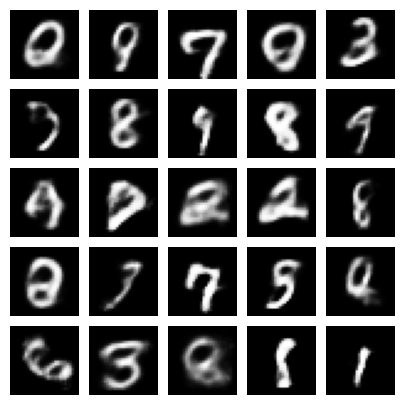

In [55]:
# Generate some new images from random latent vectors
with torch.no_grad():
  # Sample random latent vectors from a standard normal distribution
  z = torch.randn(25, latent_dim).to(device)
  # Decode them into images
  out = model.decode(z).cpu()
  # Reshape them into 28x28 images
  out = out.view(-1, 28, 28)
  # Plot them in a grid
  fig = plt.figure(figsize=(5,5))
  grid = ImageGrid(fig, 111, nrows_ncols=(5,5), axes_pad=0.1)
  for ax, im in zip(grid, out):
    ax.imshow(im.numpy(), cmap='gray')
    ax.axis('off')
  plt.show()